In [1]:
%matplotlib inline
import xarray as xr
import intake
import util
import warnings
from cmip6_preprocessing.preprocessing import read_data

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
def get_dictionary():
    """
    Function to get the dictionary of models and ensemble members of the historical runs 
    that have all of siconc, so, and thetao
    
    Returns the dictionary, the appropriate intake-esm catalog and the list of models needed to pass
    to the next function that gets the datasets.
    """
    
    print('opening intake-esm catalog...')
    url = "https://raw.githubusercontent.com/andrewpauling/cmip6hack-so-project/master/catalogs/pangeo-cmip6.json"
    col = intake.open_esm_datastore(url)
    print('done')
    
    cat = col.search(experiment_id=['historical'], table_id=['SImon', 'Omon'],
                 grid_label='gn')
    
    uni_dict = cat.unique(['source_id', 'experiment_id', 'table_id', 'member_id'])
    
    cat = col.search(experiment_id=['historical'], table_id=['SImon', 'Omon'],
                 grid_label='gn', variable_id=['siconc', 'thetao', 'so'])
    
    print('Find the models that have all three variables...')
    models = set(uni_dict['source_id']['values']) # all the models

    for table_id in ['SImon', 'Omon']:
        if table_id == 'SImon':
            query = dict(experiment_id='historical', table_id=table_id, 
                         variable_id='siconc', grid_label='gn')  
            cat = col.search(**query)
            models = models.intersection({model for model in cat.df.source_id.unique().tolist()})
        else:
            for variable_id in ['thetao', 'so']:
                query = dict(experiment_id='historical', table_id=table_id, 
                             variable_id=variable_id, grid_label='gn')  
                cat = col.search(**query)
                models = models.intersection({model for model in cat.df.source_id.unique().tolist()})
                
    models = list(models)
    print('Done')
    
    cat = col.search(experiment_id='historical', table_id=['Omon', 'SImon'], 
                 variable_id=['siconc', 'thetao', 'so'], grid_label='gn', source_id=models)
    
    print('Make sure all three variables have the same ensemble member...')
    filt_dict = dict()

    for model in models:
        tmp2 = cat.search(source_id=model)
        tmp2.df.head()
        members = tmp2.df['member_id']
        memlist = list()
        for member in list(members):
            a = tmp2.search(member_id=member, variable_id='siconc').df['activity_id'].empty
            b = tmp2.search(member_id=member, variable_id='thetao').df['activity_id'].empty
            c = tmp2.search(member_id=member, variable_id='so').df['activity_id'].empty
            if not a and not b and not c and member not in memlist:
                memlist.append(member)
        filt_dict[model] =  memlist
        
    print('Done')
    
    return filt_dict, cat, models

In [3]:
def get_datasets(filt_dict, cat, models):
    """
    Function to load the dataset dictionaries for each of the variables siconc, so, thetao. Takes in the output
    of get_dictionary()
    Returns the dataset dictonary for each variable. Separate one for each variable due to problems with intake-esm 
    for some models
    """
        
    icedict = dict()
    sodict = dict()
    thetaodict = dict()
    for model in models:
        print(model)
        tmpice = cat.search(source_id=model, member_id=filt_dict[model], variable_id='siconc')
        tmpdict_ice = tmpice.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                             cdf_kwargs={'chunks': {}, 'decode_times': False})
        icedict.update(tmpdict_ice)
        tmpice = None
        tmpdictice = None
    
        tmpso = cat.search(source_id=model, member_id=filt_dict[model], variable_id='so')
        tmpdict_so = tmpso.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                           cdf_kwargs={'chunks': {}, 'decode_times': False})
        sodict.update(tmpdict_so)
        tmpso = None
        tmpdictso = None
    
        tmpthetao = cat.search(source_id=model, member_id=filt_dict[model], variable_id='thetao')
        tmpdict_thetao = tmpthetao.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                                   cdf_kwargs={'chunks': {}, 'decode_times': False})
        thetaodict.update(tmpdict_thetao)
        tmpthetao = None
        tmpdictthetao = None
    
    return icedict, sodict, thetaodict

In [4]:
[filt_dict, cat, models] = get_dictionary()

opening intake-esm catalog...
done
Find the models that have all three variables...
Done
Make sure all three variables have the same ensemble member...
Done


In [5]:
# filt_dict, cat, models = get_dictionary()
icedict, sodict, thetaodict = get_datasets(filt_dict, cat, models)

EC-Earth3-Veg
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
MIROC6
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are con

In [6]:
ops = sodict.keys()

In [6]:
# one model has inconsistencies b/w time grid so remove it
sodict.pop('CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn')
thetaodict.pop('CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn')
icedict.pop('CMIP.CAMS.CAMS-CSM1-0.historical.SImon.gn')

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 200, member_id: 1, time: 1980, vertices: 4)
Coordinates:
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * time                (time) float64 15.5 45.0 74.5 ... 6.018e+04 6.021e+04
  * j                   (j) int32 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
  * member_id           (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(200, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(200, 360, 4), meta=np.ndarray>
    type                |S7 ...
    time_bnds           (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    latitude            (j, i) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    siconc           

In [7]:
# load some more libraries
import numpy as np
from cmip6_preprocessing.preprocessing import rename_cmip6
import gsw

In [8]:
thetaodict.keys()

dict_keys(['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn', 'CMIP.CCCma.CanESM5.historical.Omon.gn', 'CMIP.SNU.SAM0-UNICON.historical.Omon.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn', 'CMIP.MIROC.MIROC6.historical.Omon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Omon.gn', 'CMIP.NUIST.NESM3.historical.Omon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Omon.gn', 'CMIP.MOHC.HadGEM3-GC31-LL.historical.Omon.gn', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn', 'CMIP.NCAR.CESM2.historical.Omon.gn'])

In [9]:
threekeys= ['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn',
            'CMIP.CCCma.CanESM5.historical.Omon.gn', 
            'CMIP.MOHC.HadGEM3-GC31-LL.historical.Omon.gn']

In [10]:
thetaodict_small={}
sodict_small ={}
# rename all variables to be the same 
for i in threekeys:
    thetaodict_small[i] = rename_cmip6(thetaodict[i])

for i in threekeys:
    sodict_small[i] = rename_cmip6(sodict[i])    

/srv/conda/envs/notebook/lib/python3.7/site-packages/cmip6_preprocessing-0+untagged.5.g1b9d6ba.dirty-py3.7.egg/cmip6_preprocessing/preprocessing.py:129: UserWarning: Variable [lev_bounds] not found in Coordinates:
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * bnds       (bnds) float64 1.0 2.0
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
  * member_id  (member_id) <U8 'r1i1p1f1'
/srv/conda/envs/notebook/lib/python3.7/site-packages/cmip6_preprocessing-0+untagged.5.g1b9d6ba.dirty-py3.7.egg/cmip6_preprocessing/preprocessing.py:129: UserWarning: Variable [lev_bounds] not found in Coordinates:
  * lev        (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * time       (ti

In [18]:
sodict_small

{'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn': <xarray.Dataset>
 Dimensions:     (bnds: 2, lev: 35, member_id: 1, time: 1980, vertex: 4, x: 1440, y: 1080)
 Coordinates:
   * lev         (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
   * x           (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
   * bnds        (bnds) float64 1.0 2.0
   * y           (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
   * time        (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
   * member_id   (member_id) <U8 'r1i1p1f1'
 Dimensions without coordinates: vertex
 Data variables:
     lev_bnds    (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
     lon         (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
     lon_bounds  (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
     time_bnds   (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
     lat_bounds  (

In [23]:
# start the process of estimating the densities. 
deriveddict= {}

In [24]:
for i in sodict_small:
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, sodict_small[i].so, thetaodict_small[i].thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
    deriveddict[i] = cthetao

In [25]:
deriveddict

{'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (lev: 35, member_id: 1, time: 1980, x: 1440, y: 1080)
 Coordinates:
   * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
   * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
   * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
   * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
   * member_id  (member_id) <U8 'r1i1p1f1'
 Data variables:
     cthetao    (member_id, time, lev, y, x) float64 dask.array<chunksize=(1, 1, 35, 1080, 1440), meta=np.ndarray>,
 'CMIP.CCCma.CanESM5.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (lev: 45, member_id: 1, time: 1980, x: 360, y: 291)
 Coordinates:
   * lev        (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
   * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
   * time       (time) int64 0 708 1416 2148 ... 144246

In [26]:
for i in deriveddict:    
    pdens=xr.apply_ufunc(gsw.density.sigma2,sodict_small[i].so, deriveddict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('pdens').to_dataset()
    deriveddict[i] = xr.merge([pdens, deriveddict[i]])

In [27]:
deriveddict

{'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (lev: 35, member_id: 1, time: 1980, x: 1440, y: 1080)
 Coordinates:
   * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
   * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
   * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
   * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
   * member_id  (member_id) <U8 'r1i1p1f1'
 Data variables:
     pdens      (member_id, time, lev, y, x) float64 dask.array<chunksize=(1, 1, 35, 1080, 1440), meta=np.ndarray>
     cthetao    (member_id, time, lev, y, x) float64 dask.array<chunksize=(1, 1, 35, 1080, 1440), meta=np.ndarray>,
 'CMIP.CCCma.CanESM5.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (lev: 45, member_id: 1, time: 1980, x: 360, y: 291)
 Coordinates:
   * lev        (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
   * x          (x) 

In [28]:
import matplotlib.pyplot as plt
# specific plotting stuff from Lettie
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma

In [29]:
bottom_props = {}

In [30]:
for (n,i) in enumerate(deriveddict):
    print(thetaodict[i].attrs['source_id'])
    
    ds = deriveddict[i]
    dstemp = thetaodict_small[i]
    dssalt = sodict_small[i]
    
    temp = ds.pdens + ds.lev
    
    bottom_dens = ds.pdens.where(temp==temp.max(['lev'])).max(['lev']).isel(time=-1)
    bottom_temp = dstemp.thetao.where(temp==temp.max(['lev'])).max(['lev']).isel(time=-1)
    bottom_salt = dssalt.so.where(temp==temp.max(['lev'])).max(['lev']).isel(time=-1)
    topo = (temp- ds.pdens).isel(time=-1).max(['lev']).rename('topo')
    
    bottom_props[i] = xr.merge([bottom_dens, bottom_temp, bottom_salt, topo])

GFDL-CM4
CanESM5
HadGEM3-GC31-LL


In [32]:
bottom_props

{'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (member_id: 1, x: 1440, y: 1080)
 Coordinates:
   * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
   * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
     time       int64 1444656
   * member_id  (member_id) <U8 'r1i1p1f1'
 Data variables:
     pdens      (member_id, y, x) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
     thetao     (member_id, y, x) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
     so         (member_id, y, x) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
     topo       (member_id, y, x) float64 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>,
 'CMIP.CCCma.CanESM5.historical.Omon.gn': <xarray.Dataset>
 Dimensions:    (member_id: 1, x: 360, y: 291)
 Coordinates:
   * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
     time       int64 1444656
   * y  

In [33]:
for i in bottom_props:
    bottom_props[i].load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

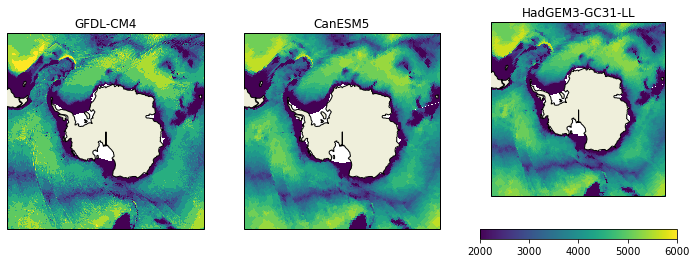

In [49]:
fig = plt.figure(figsize=(12,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    
    im = ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].topo.isel(member_id=-1),
                  transform=ccrs.PlateCarree(), vmin=2000, vmax=6000)
    
    if n ==2:
       
        fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05)
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    #ax.set_ylim([0,int(len(ds.y)/3)])
    
    ax.set_title(ds.attrs['source_id'])

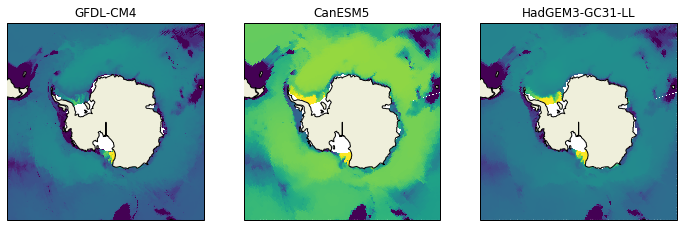

In [57]:
fig = plt.figure(figsize=(12,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    
    im = ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].pdens.isel(member_id=-1),
                  transform=ccrs.PlateCarree(), vmin=36.8, vmax=37.2)
    
    #if n ==2:
    #    fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05)
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    #ax.set_ylim([0,int(len(ds.y)/3)])
    
    ax.set_title(ds.attrs['source_id'])

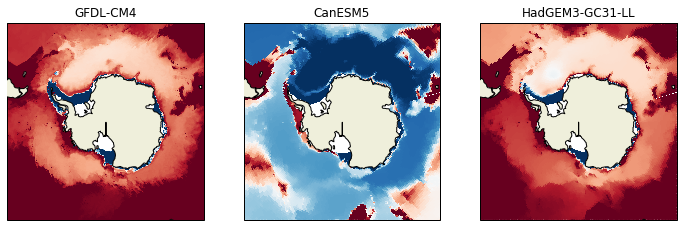

In [64]:
fig = plt.figure(figsize=(12,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    
    im = ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].thetao.isel(member_id=-1),
                  transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap='RdBu_r')
    
    #if n ==2:
    #    fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05)
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    #ax.set_ylim([0,int(len(ds.y)/3)])
    
    ax.set_title(ds.attrs['source_id'])

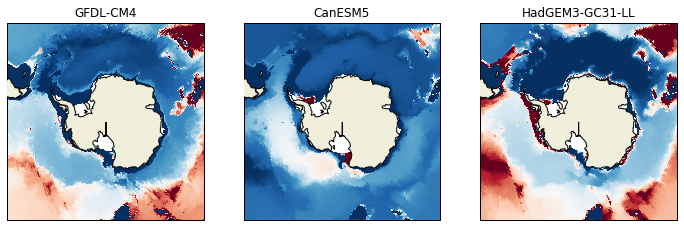

In [63]:
fig = plt.figure(figsize=(12,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    
    im = ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].so.isel(member_id=-1),
                  transform=ccrs.PlateCarree(), vmin=34.65, vmax=34.75, cmap='RdBu_r')
    
    #if n ==2:
    #    fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05)
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    #ax.set_ylim([0,int(len(ds.y)/3)])
    
    ax.set_title(ds.attrs['source_id'])

In [6]:
## Observations 
# Read WOA using opendap
Temp_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA13/5_deg/annual/temp'
Salt_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA13/5_deg/annual/salt'
#Oxy_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA13/5_deg/annual/doxy'

ds = xr.merge([
    xr.open_dataset(Temp_url).tmn.load(),
    xr.open_dataset(Salt_url).smn.load(),
    #xr.open_dataset(Oxy_url).omn.load()])
ds

SyntaxError: unexpected EOF while parsing (<ipython-input-6-f6c4a60ce38e>, line 11)

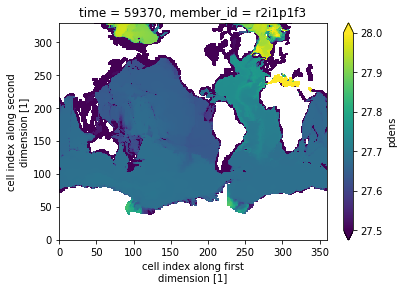

In [110]:
bottom_props[i].pdens.isel(member_id=-1).plot(vmin=27.5,vmax=28)

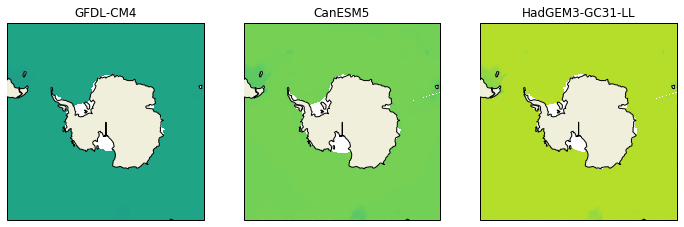

In [106]:
plt.figure(figsize=(12,4))
for (n,i) in enumerate(bottom_props): 
    
    ds= thetaodict_small[i]
    
    ax = plt.subplot(1,3,n+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    ax.pcolormesh(ds.lon, ds.lat, bottom_props[i].pdens.isel(member_id=-1),
                  transform=ccrs.PlateCarree(), vmin)
    
    
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    #ax.set_ylim([0,int(len(ds.y)/3)])
    
    ax.set_title(ds.attrs['source_id'])

In [61]:
bottom_props.keys()

dict_keys(['CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Omon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Omon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


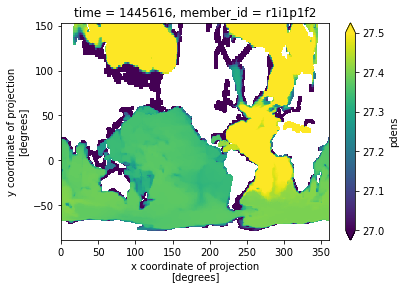

In [67]:
bottom_props['CMIP.MIROC.MIROC-ES2L.historical.Omon.gn'].pdens.isel(member_id=-1).plot(vmin=27, vmax=27.5)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


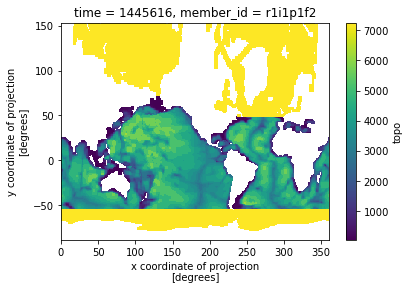

In [64]:
bottom_props['CMIP.MIROC.MIROC-ES2L.historical.Omon.gn'].topo.isel(member_id=-1).plot()

In [ ]:
deriveddict

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


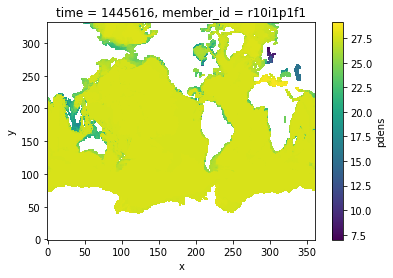

In [45]:
bottom_props[i].pdens.isel(member_id=-1).plot()

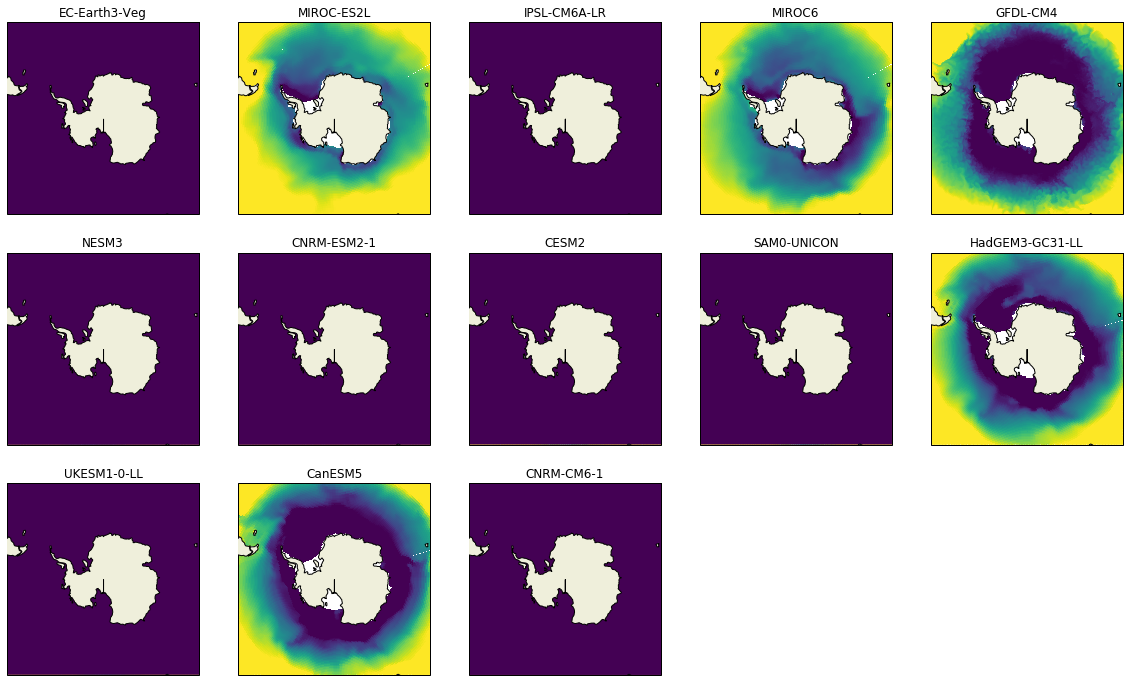

In [75]:
plt.figure(figsize=(20,12))
# estimate the bottom density, temp, salinity in all the models.
for (n,i) in enumerate(thetaodict):
    
    ds = thetaodict[i]
    
    ax = plt.subplot(3,5,n+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    
    #ax = plt.subplot(3,5,n+1)
    ax.pcolormesh(ds.lon, ds.lat, ds.thetao.isel(member_id=-1, time=-1, lev=0),
                  transform=ccrs.PlateCarree(),vmin=-1, vmax=10)
    
    
    #ax = plt.subplot(3,5,n+1) 
    #ax.pcolormesh(ds.lon, ds.lat,ds.thetao.isel(member_id=-1, time=-1, lev=0))
    #ax.set_ylim([0,int(len(ds.y)/3)])
    
    ax.set_title(ds.attrs['source_id'])
    

In [1]:
2+2

4